In [1]:
%pip install -q opencv-python-headless numpy
%pip install -q scikit-image imutils

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Imports & paths


In [2]:
from pathlib import Path
import os
import cv2
import numpy as np
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt


from skimage.segmentation import clear_border
import imutils


# Paths (edit here)
DATA_DIR = Path('/kaggle/input/datasets/mahyarrajaei/vehicle-license-samples')
THRESHOLD = 0.5
SCALES = (1.0, 0.1)

# Basic checks
assert DATA_DIR.exists(), f'Data folder not found: {DATA_DIR}'
image_files = sorted([p for p in DATA_DIR.iterdir()])
print(f'Found {len(image_files)} JPEGs in {DATA_DIR}')

Found 2 JPEGs in /kaggle/input/datasets/mahyarrajaei/vehicle-license-samples


## 3. Plate localization heuristics

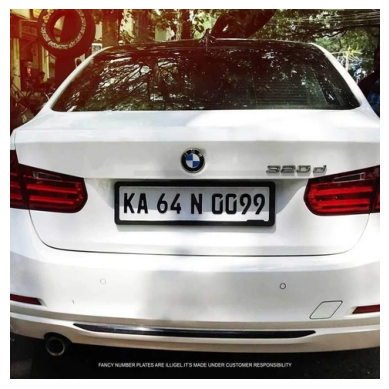

In [3]:
img = cv2.imread(str(image_files[1]))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
    

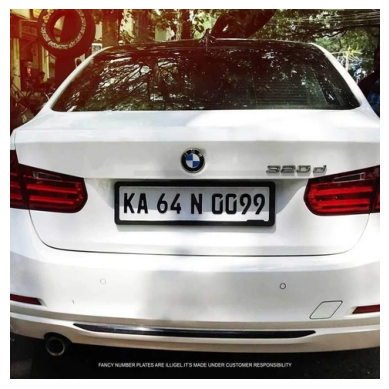

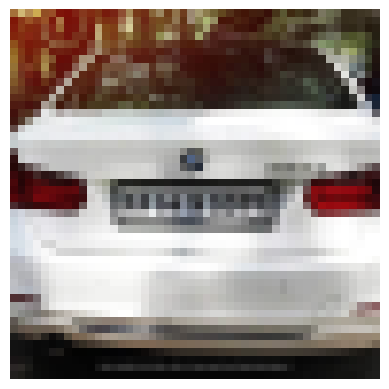

In [4]:
imgs = []
H0, W0 = img.shape[:2]
for s in SCALES:
        Ws = int(W0 * s)
        Hs = int(H0 * s)
        scaled = cv2.resize(img, (Ws, Hs), interpolation=cv2.INTER_AREA)
        imgs.append(scaled)
        plt.imshow(cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [5]:
def apply_blackhat(img, debug=False):
    gray =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # gray_clahe = clahe.apply(gray)

    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
    if debug:
        plt.imshow(blackhat, cmap='gray')
        plt.title("Blackhat")
        plt.axis('off')
        plt.show()
    return blackhat

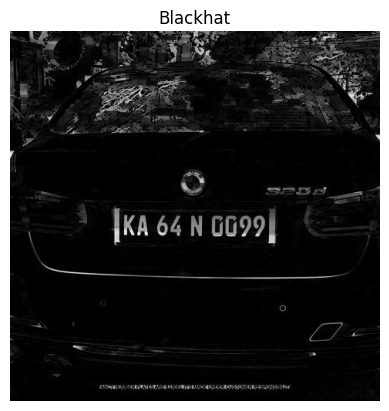

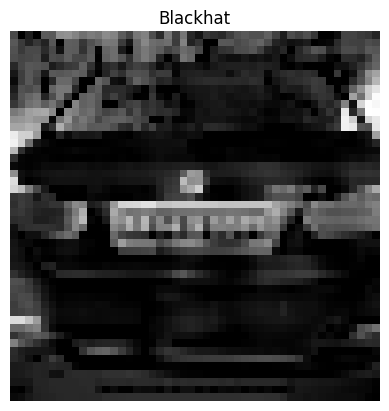

In [6]:
blackhats = [apply_blackhat(img, debug=True) for img in imgs]

In [7]:
def apply_scharr(img, debug=False):
    gradX = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
    gradX = gradX.astype("uint8")
    if debug:
        plt.imshow(gradX, cmap='gray')
        plt.title("Scharr")
        plt.axis('off')
        plt.show()
    return gradX

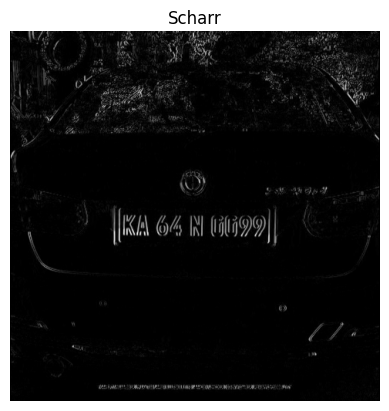

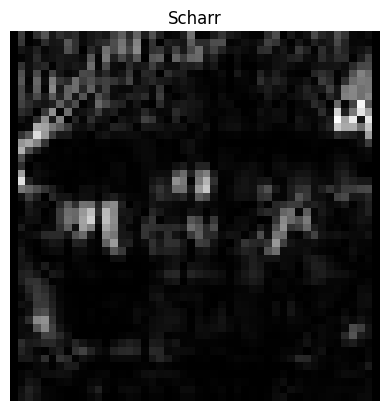

In [8]:
gradXs = [apply_scharr(blackhat, debug=True) for blackhat in blackhats]

In [9]:
# blur the gradient representation, applying a closing
# operation, and threshold the image using Otsu's method
def blur_gradient(gradX, debug=False):
    gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
    thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    if debug:
        plt.imshow(thresh, cmap='gray')
        plt.title("Grad Thresh")
        plt.axis('off')
        plt.show()
    return thresh

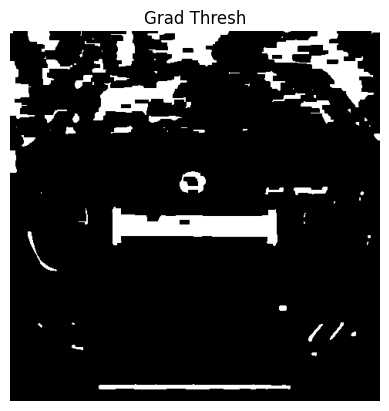

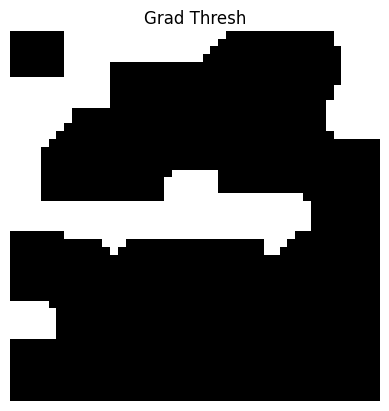

In [10]:
threshs = [blur_gradient(gradX, debug=True) for gradX in gradXs]

In [11]:
def clean_gradient(thresh, debug=False):
    # perform a series of erosions and dilations to clean up the
    # thresholded image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, rectKern)
    if debug:
        plt.imshow(thresh, cmap='gray')
        plt.title("Grad Erode/Dilate")
        plt.axis('off')
        plt.show()
    return thresh

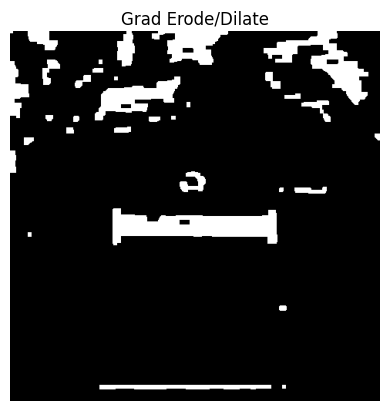

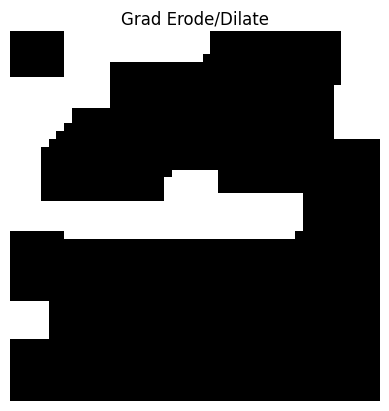

In [12]:
threshs = [clean_gradient(thresh, debug=True) for thresh in threshs]

In [13]:
# squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
# light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# plt.imshow(light, cmap='gray')
# plt.title("Light Regions")
# plt.axis('off')
# plt.show()


In [14]:
# find contours in the thresholded image and sort them by
# their size in descending order, keeping only the largest
# ones
def get_candidate_contours(thresh, keep=5):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]
    return cnts


In [15]:
scaled_cnts = [get_candidate_contours(thresh, keep=5) for thresh in threshs]

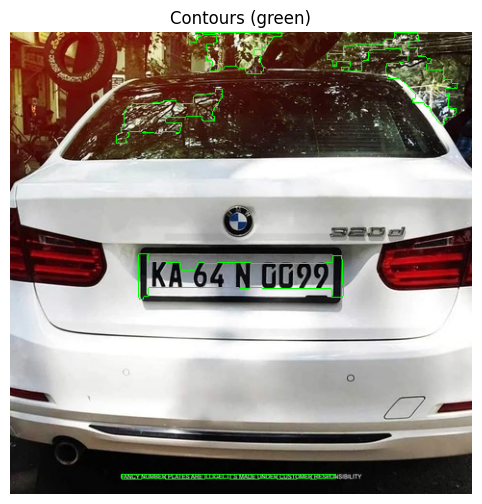

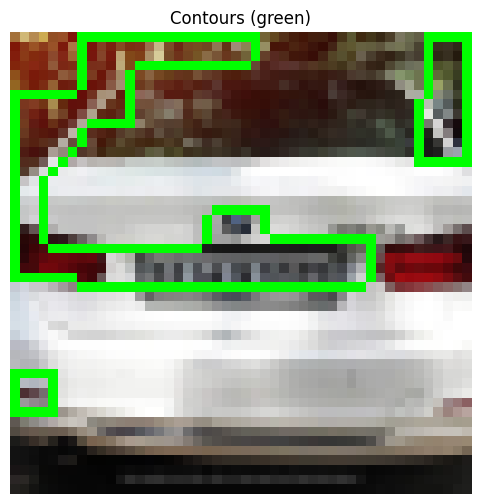

In [16]:
for i, img in enumerate(imgs):
    draw = img.copy()
    cv2.drawContours(draw, scaled_cnts[i], contourIdx=-1, color=(0, 255, 0), thickness=1)

    # Matplotlib expects RGB
    draw_rgb = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(draw_rgb)
    plt.title("Contours (green)")
    plt.axis("off")
    plt.show()

In [17]:
def get_roi(cnts, img, thresh, pad_style="fixed", pad_value=20, pad_proportion=0.10, debug=False):
    for i, c in enumerate(cnts):
        x, y, w, h = cv2.boundingRect(c)

        # padding: choose ONE of the following styles

        # (A) fixed padding in pixels
        # pad = 4 * int(0.05 * max(abs(w - x), abs(h - y))) 
        pad = 20
        print(pad)

        # (B) padding proportional to contour size (e.g., 10% of max(w,h))
        # pad = int(0.10 * max(w, h))

        # clamp to image boundaries
        x1 = max(x - pad, 0)
        y1 = max(y - pad, 0)
        x2 = min(x + w + pad, thresh.shape[1])
        y2 = min(y + h + pad, thresh.shape[0])

        roi = img[y1:y2, x1:x2]

        # Example: visualize the padded box on an image   
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

20


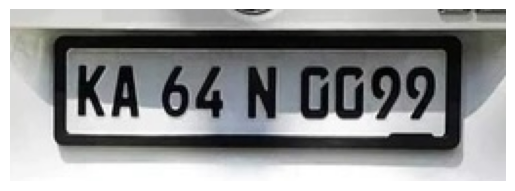

20


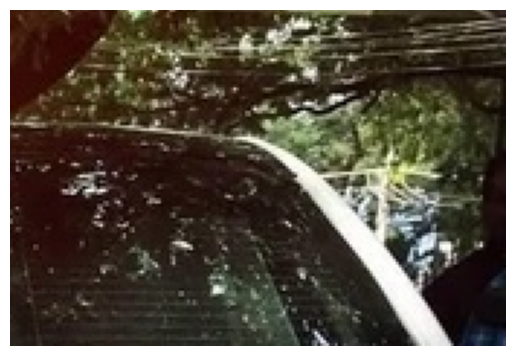

20


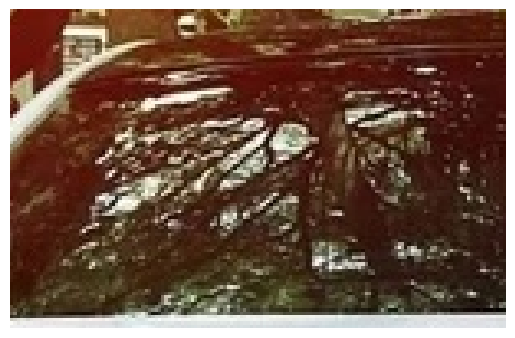

20


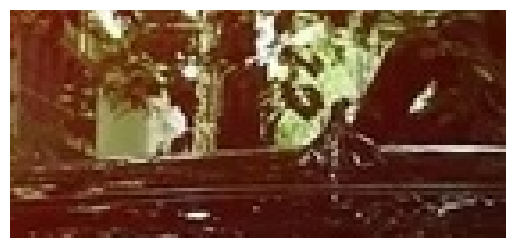

20


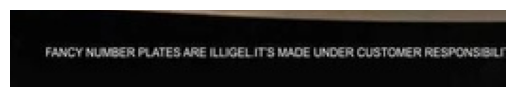

20


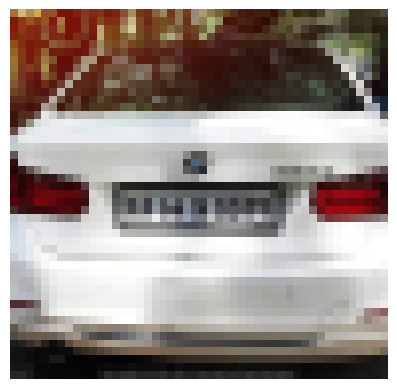

20


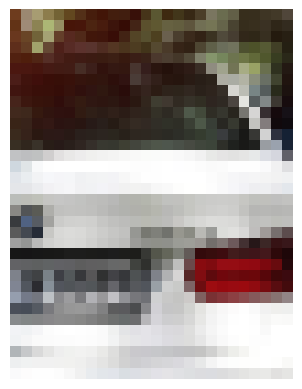

20


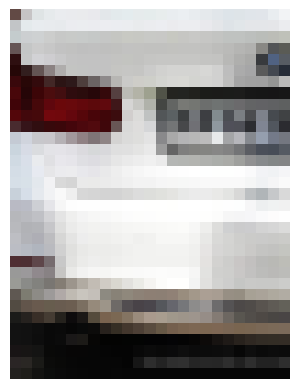

In [18]:
for i, img in enumerate(imgs):
    get_roi(scaled_cnts[i], img, threshs[i], pad_style="fixed", pad_value=20, debug=True)

In [19]:
import cv2
import numpy as np

def order_points(pts):
    # pts: (4,2)
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]      # top-left
    rect[2] = pts[np.argmax(s)]      # bottom-right
    rect[1] = pts[np.argmin(diff)]   # top-right
    rect[3] = pts[np.argmax(diff)]   # bottom-left
    return rect

def four_point_warp(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute new width/height
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxW = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxH = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxW - 1, 0],
        [maxW - 1, maxH - 1],
        [0, maxH - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxW, maxH))
    return warped, M


In [20]:
minAR=1.5
maxAR=6.5

In [21]:
def license_plate_candidates(img, candidates, thresh, clearBorder=False, pad=20, debug=False):
    candidate_rois = []
    # initialize the license plate contour and ROI
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    lpCnt = None
    roi = None
    # loop over the license plate candidate contours
    for c in candidates:
        # compute the bounding box of the contour and then use
        # the bounding box to derive the aspect ratio
        (x, y, w, h) =  cv2.boundingRect(c)
        ar = w / float(h)
        if debug:
            print(f"Contour at (x={x}, y={y}, w={w}, h={h}) has aspect ratio {ar:.2f}")
 
        # check to see if the aspect ratio is rectangular
        if ar >= minAR and ar <= maxAR:

            x1 = max(x - pad, 0)
            y1 = max(y - pad, 0)
            x2 = min(x + w + pad, thresh.shape[1])
            y2 = min(y + h + pad, thresh.shape[0])

            roi_warped = img[y1:y2, x1:x2]


            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect).astype(np.float32) 
            # 3) Shift box points into ROI coordinate system
            box_roi = box.copy()
            box_roi[:, 0] -= x1
            box_roi[:, 1] -= y1
            

            # 4) Warp the ROI using shifted points
            warped, M = four_point_warp(roi_warped, box_roi)
            
            warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

            
            dbg = roi_warped.copy()
            cv2.polylines(dbg, [box_roi.astype(int)], True, (0, 255, 0), 1)



            # store the license plate contour and extract the
            # license plate from the grayscale image and then
            # threshold it
            lpCnt = c
            # licensePlate = gray[y:y + h, x:x + w]
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
            warped_gray = clahe.apply(warped_gray)
            warped_gray = cv2.resize(warped_gray, None, fx=50, fy=50, interpolation=cv2.INTER_CUBIC)
            
            

            
            warped_gray = cv2.GaussianBlur(warped_gray, (101, 101), 0)
            roi_global_th = cv2.threshold(warped_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            
            
            roi_adaptive_th = cv2.adaptiveThreshold(
                warped_gray,
                255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # or cv2.ADAPTIVE_THRESH_MEAN_C
                cv2.THRESH_BINARY_INV,           # use THRESH_BINARY if you want white background
                301,                              # blockSize (odd number)
                28                                # C (smaller keeps more strokes)
            )





            k0 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
            # roi = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, k, iterations=1)
            roi_global_th = cv2.morphologyEx(roi_global_th, cv2.MORPH_CLOSE, k0, iterations=1)
            roi_global_th = cv2.erode(roi_global_th, k1, iterations=30)
            roi_global_th = cv2.dilate(roi_global_th, k1, iterations=5)

            roi_adaptive_th = cv2.morphologyEx(roi_adaptive_th, cv2.MORPH_CLOSE, k0, iterations=1)
            roi_adaptive_th = cv2.erode(roi_adaptive_th, k1, iterations=5)
            roi_adaptive_th = cv2.dilate(roi_adaptive_th, k1, iterations=5)


            # check to see if we should clear any foreground
            # pixels touching the border of the image
            # (which typically, not but always, indicates noise)
            # if clearBorder:
            #     roi = clear_border(roi)
            if clearBorder:
                pad_cb = 40  # try 15–40 depending on ROI size

                roi_bool_global = (roi_global_th > 0)  # convert uint8->bool
                roi_pad_global = np.pad(roi_bool_global, ((pad_cb, pad_cb), (pad_cb, pad_cb)),
                                mode="constant", constant_values=False)
                
                roi_bool_adaptive = (roi_adaptive_th > 0)  # convert uint8->bool
                roi_pad_adaptive = np.pad(roi_bool_adaptive, ((pad_cb, pad_cb), (pad_cb, pad_cb)),
                                mode="constant", constant_values=False)

                roi_clean_pad_global = clear_border(roi_pad_global)
                roi_clean_pad_adaptive = clear_border(roi_pad_adaptive)

                roi_global_th = (roi_clean_pad_global[pad_cb:-pad_cb, pad_cb:-pad_cb].astype("uint8")) * 255
                roi_adaptive_th = (roi_clean_pad_adaptive[pad_cb:-pad_cb, pad_cb:-pad_cb].astype("uint8")) * 255
            
            candidate_rois.append((warped_gray, roi_global_th))
            candidate_rois.append((warped_gray, roi_adaptive_th))

            if debug:
                plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
                plt.title("Debug ROI")
                plt.axis('off')
                plt.show()
                
                
                plt.imshow(warped_gray, cmap='gray')
                plt.title("Warped License Plate")
                plt.axis('off')
                plt.show()
                
                plt.imshow(roi_global_th, cmap='gray')
                plt.title("ROI Global Theresholding")
                plt.axis('off')
                plt.show()
            
                plt.imshow(roi_adaptive_th, cmap='gray')
                plt.title("ROI Adaptive Theresholding")
                plt.axis('off')
                plt.show()
            
    # return a 2-tuple of the license plate ROI and the contour
    # associated with it
    return candidate_rois

Contour at (x=133, y=230, w=214, h=48) has aspect ratio 4.46


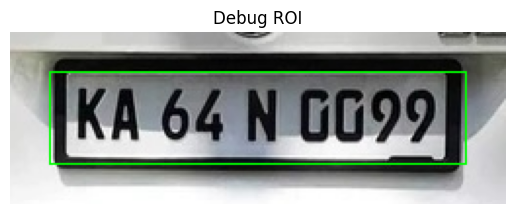

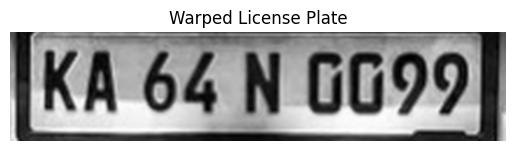

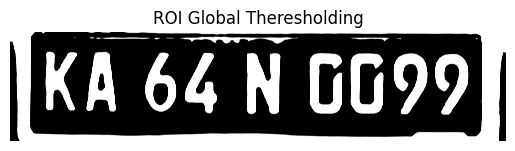

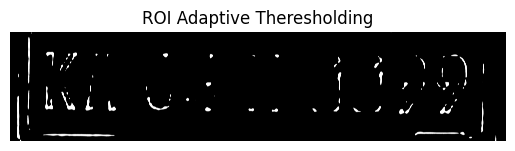

Contour at (x=329, y=0, w=136, h=96) has aspect ratio 1.42
Contour at (x=110, y=59, w=111, h=57) has aspect ratio 1.95


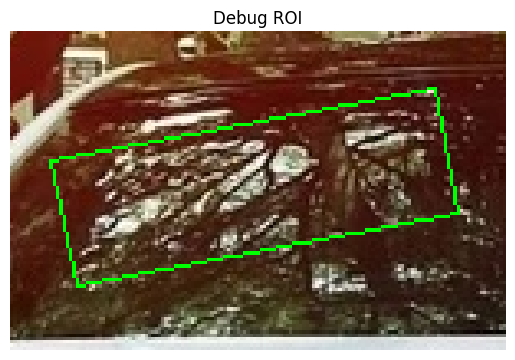

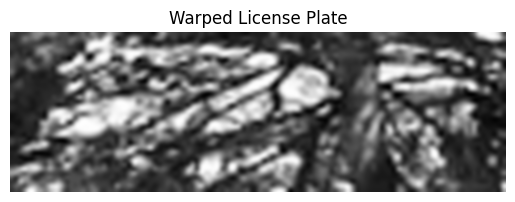

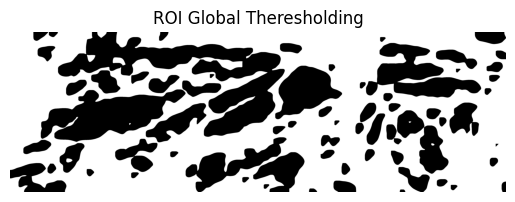

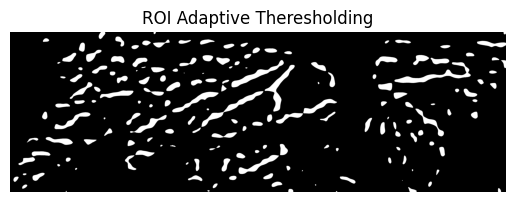

Contour at (x=184, y=0, w=99, h=44) has aspect ratio 2.25


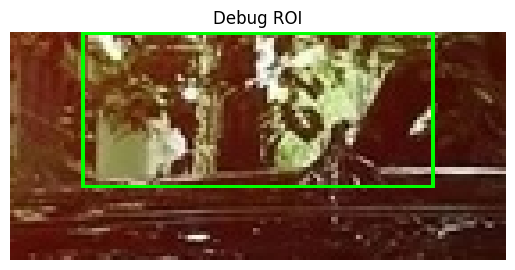

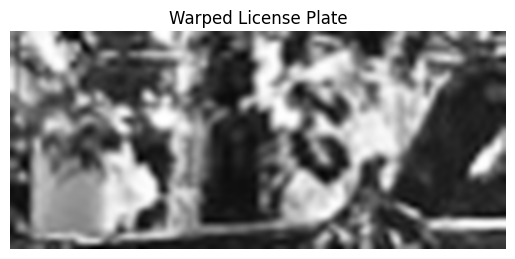

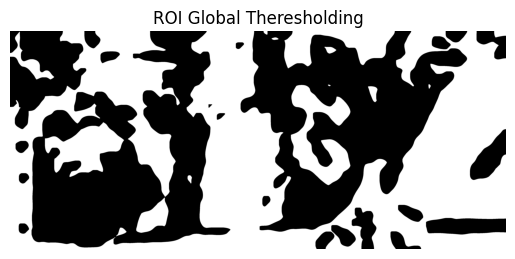

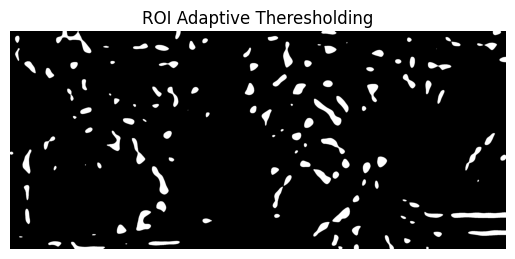

Contour at (x=116, y=459, w=223, h=6) has aspect ratio 37.17
Contour at (x=0, y=0, w=38, h=27) has aspect ratio 1.41
Contour at (x=42, y=0, w=6, h=14) has aspect ratio 0.43
Contour at (x=0, y=35, w=5, h=5) has aspect ratio 1.00


In [22]:
candidate_rois = []
for i, img in enumerate(imgs):
    candidate_rois += license_plate_candidates(img, scaled_cnts[i], threshs[i], clearBorder=True, debug=True)

----

## 4. Blocked plate scoring

In [23]:
def number_of_digits_in_roi(candidate_rois, debug=False):

    number_of_digits = dict()

    for candidate, (warped_gray, bin_image) in enumerate(candidate_rois):
        if debug:
            print(f"Scoring candidate {candidate}...")

        # ConnectedComponents expects 0 background, >0 foreground.
        # If your digits are white on black, this is fine. If inverted, flip it.
        fg = (bin_image >= 128).astype(np.uint8)

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            fg, connectivity=8
        )

        digits = 0
        asp_max = 1.0
        asp_min = 0.3
        area_min = 1500
        area_max = 160000
        min_compactness = 0
        max_compactness = 0.7

        if debug:
            plt.figure(figsize=(8,3))
            plt.imshow(labels, cmap='nipy_spectral')
            plt.title("Connected Components (each color = one component)")
            plt.axis('off')
            plt.show()
            print("num_labels (including background):", num_labels)

        for i in range(1, num_labels):
            x, y, w, h, area = stats[i]   # area = pixel count of the component

            if h <= 0 or w <= 0:
                continue

            # Mask for this component within full image
            comp_mask = (labels == i).astype(np.uint8) * 255

            # Crop to component bbox
            comp_mask_roi = comp_mask[y:y+h, x:x+w]

            # --- Compactness via contour perimeter ---
            cnts, _ = cv2.findContours(comp_mask_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not cnts:
                compactness = 0.0
                P = 0.0
            else:
                cnt = max(cnts, key=cv2.contourArea)
                P = cv2.arcLength(cnt, True)
                # Use `area` from CC (pixel count) as A; or use contour area:
                A = float(area)  # or: A = cv2.contourArea(cnt)
                compactness = float(4.0 * np.pi * A / (P * P + 1e-6))

            aspect = w / float(h)

            # --- Your area condition was: (w*h - area >= area_min) ---
            # That measures "empty space" in bbox. Usually you'd want: area >= area_min
            # Choose ONE of the two lines below:

            # common choice:
            # your original intent (if you really want it):
            area_ok = ((w*h - area) >= area_min)

            if (asp_min <= aspect <= asp_max) and area_ok and (min_compactness <= compactness < max_compactness):
                digits += 1
                if debug:
                    plt.figure(figsize=(3,3))
                    plt.imshow(comp_mask_roi, cmap='gray')
                    plt.title(
                        f"Comp {i} | area={area} | w={w} h={h} | ar={aspect:.2f} | comp={compactness:.3f}"
                    )
                    plt.axis('off')
                    plt.show()

        if debug:
            print(digits, "potential digits found based on filters")

        number_of_digits[candidate] = digits

    return number_of_digits


Scoring candidate 0...


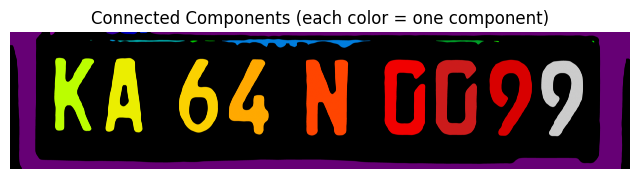

num_labels (including background): 24


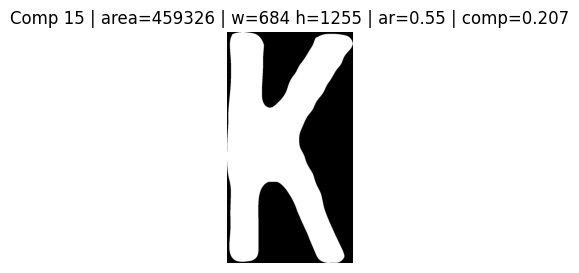

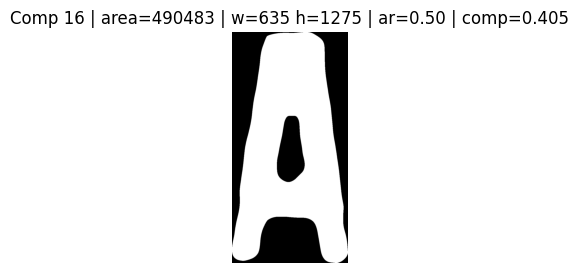

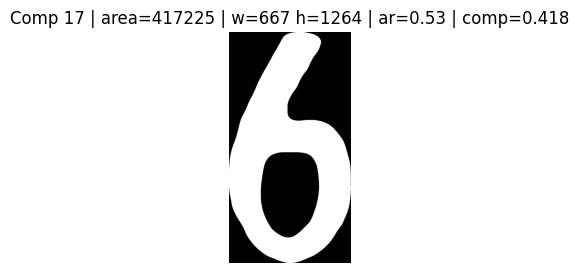

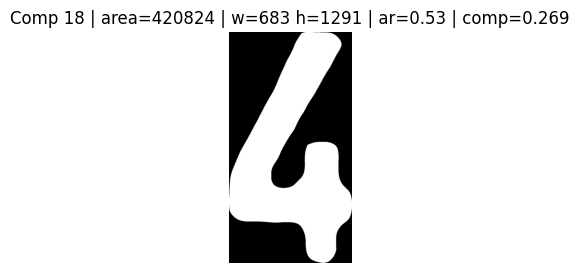

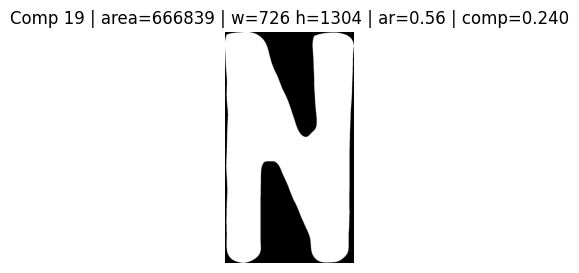

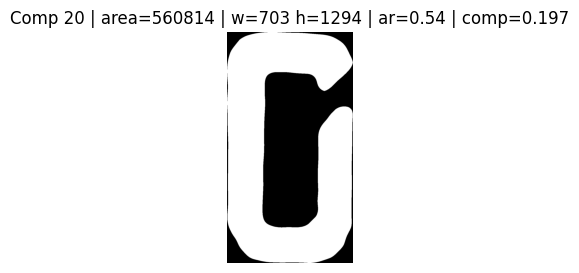

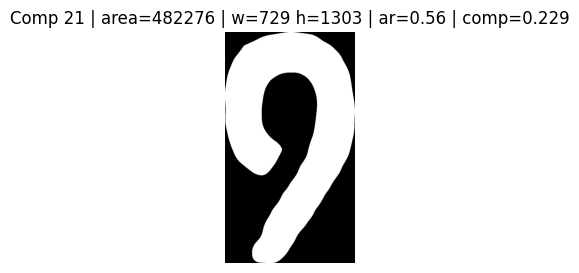

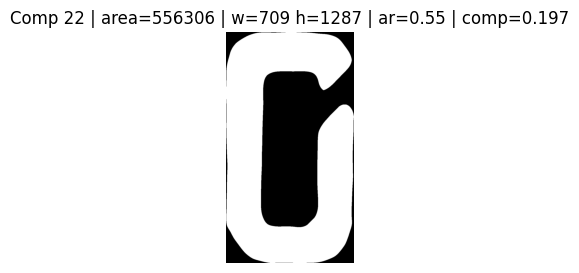

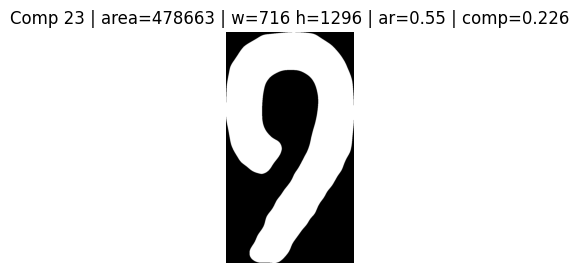

9 potential digits found based on filters
Scoring candidate 1...


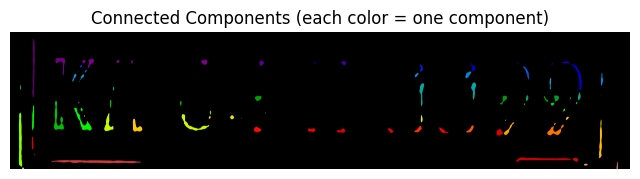

num_labels (including background): 86


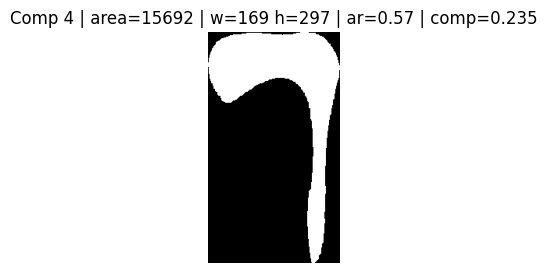

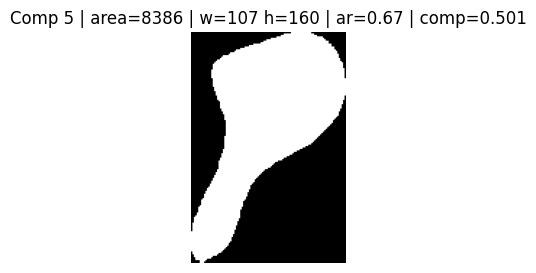

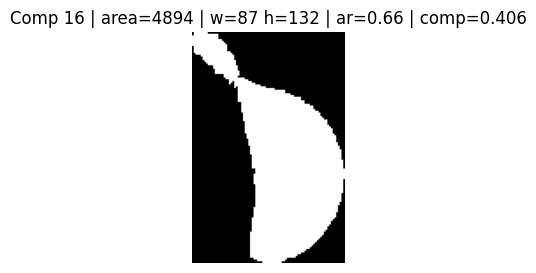

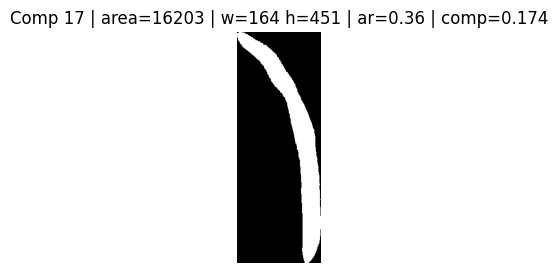

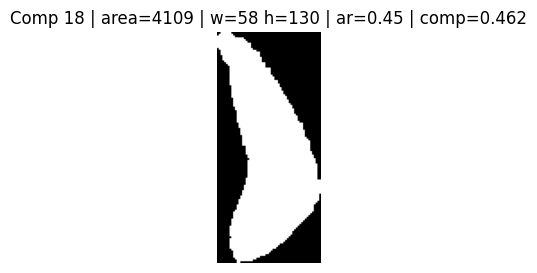

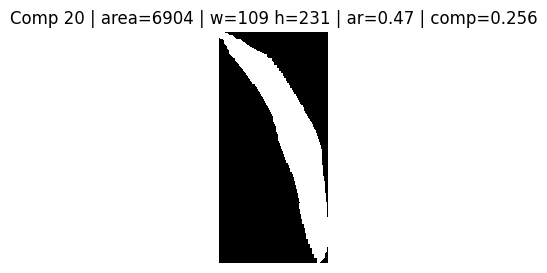

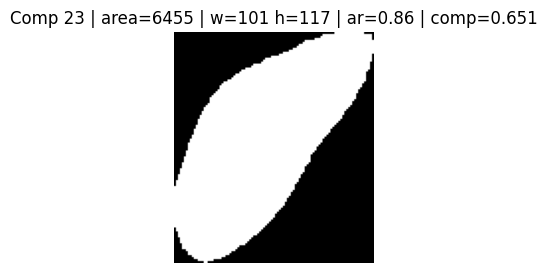

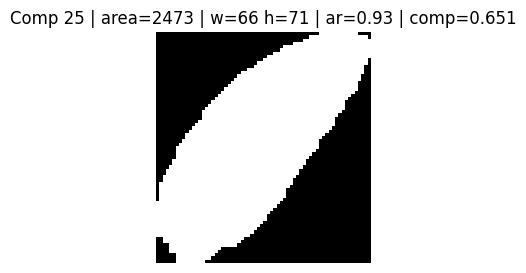

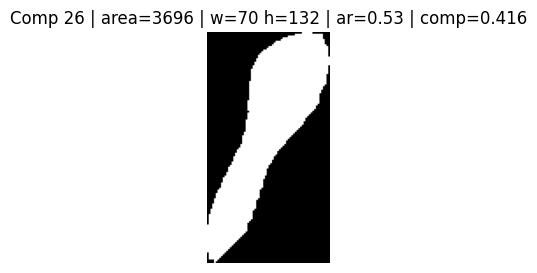

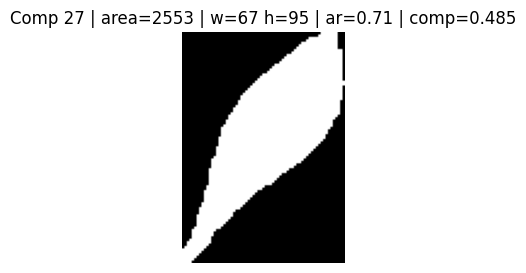

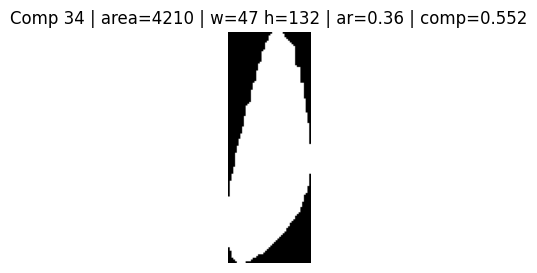

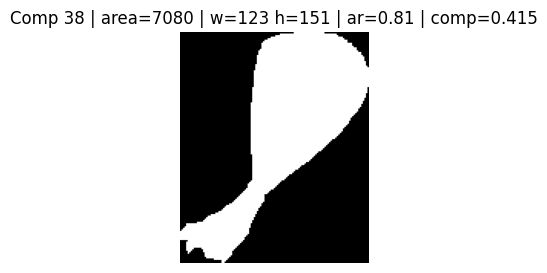

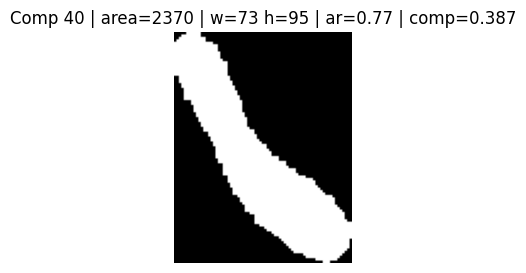

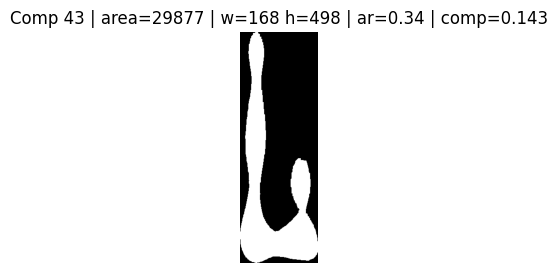

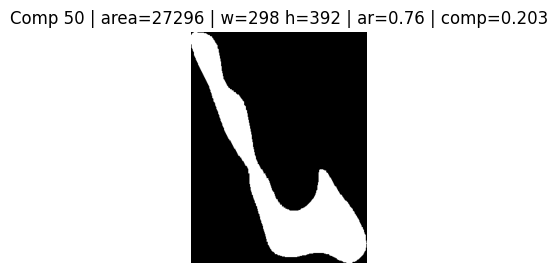

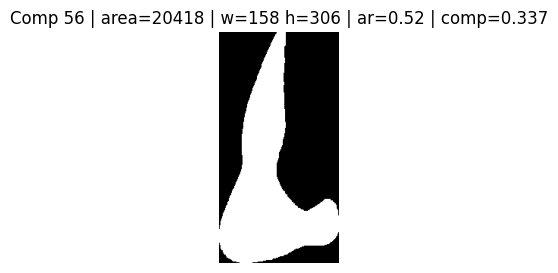

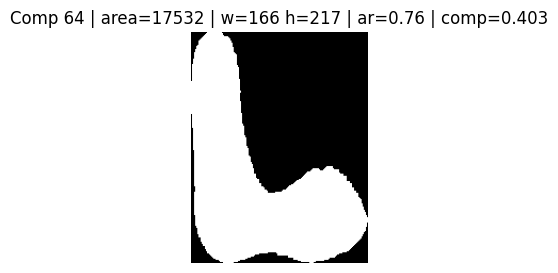

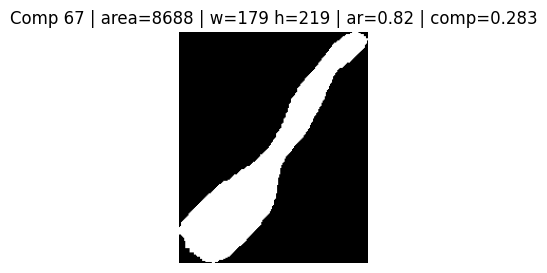

18 potential digits found based on filters
Scoring candidate 2...


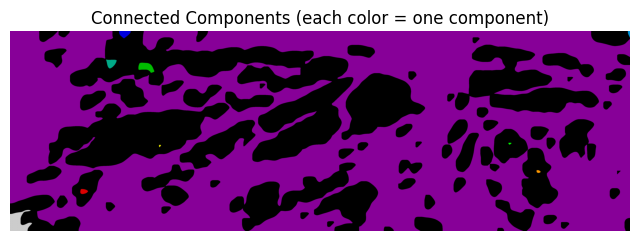

num_labels (including background): 11
0 potential digits found based on filters
Scoring candidate 3...


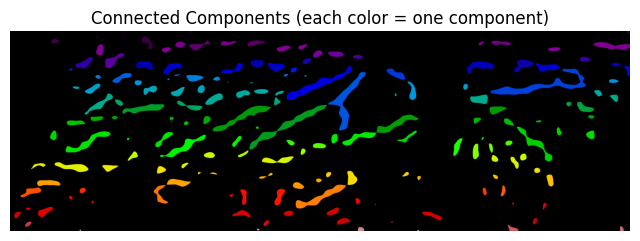

num_labels (including background): 171


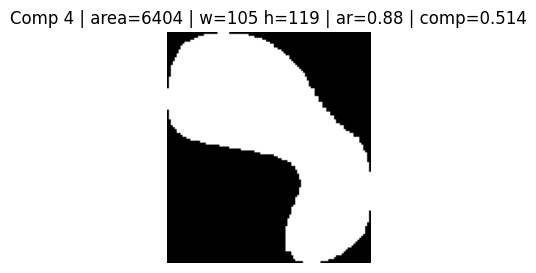

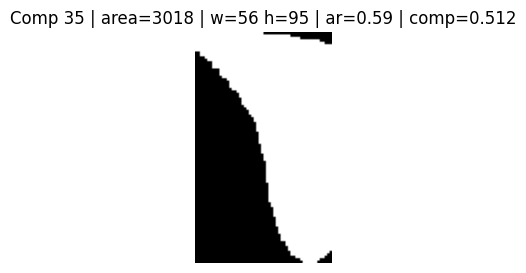

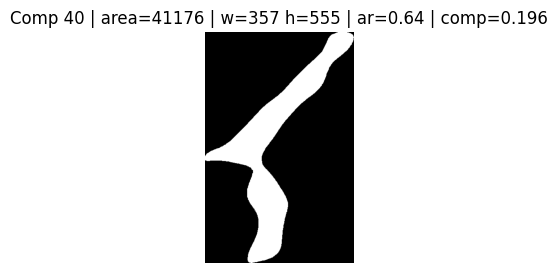

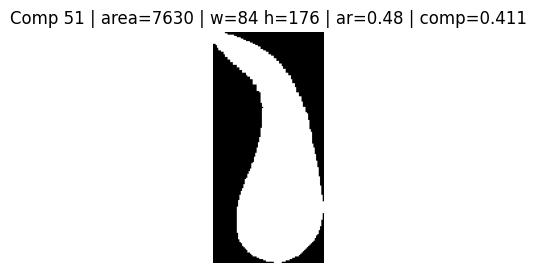

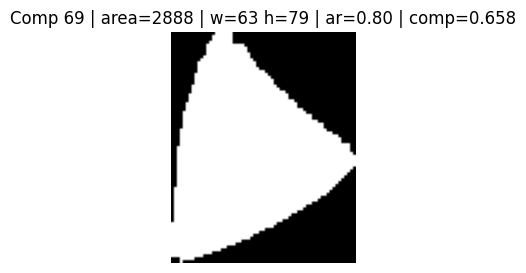

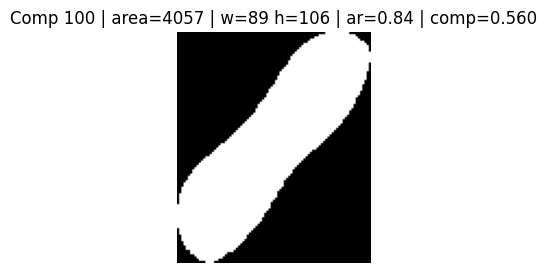

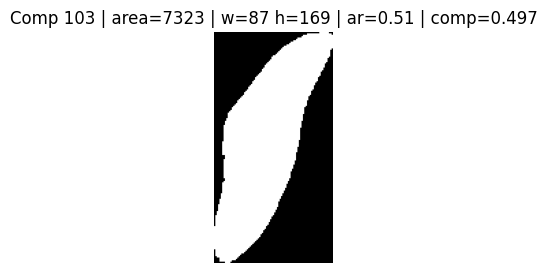

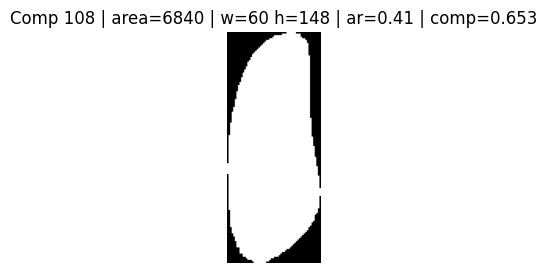

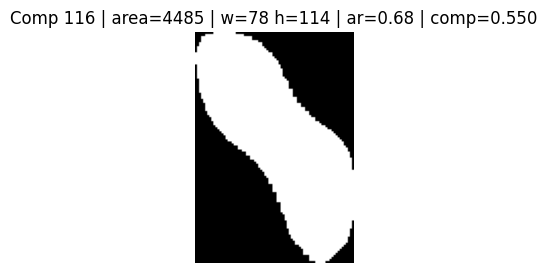

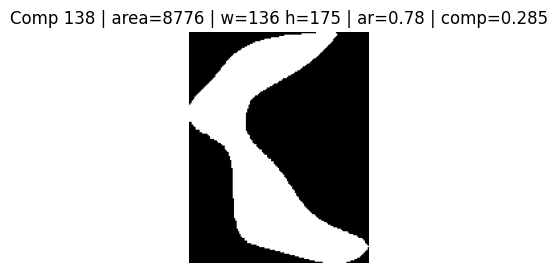

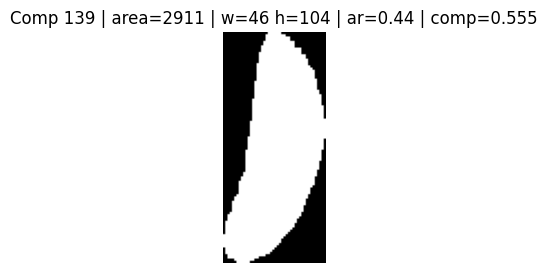

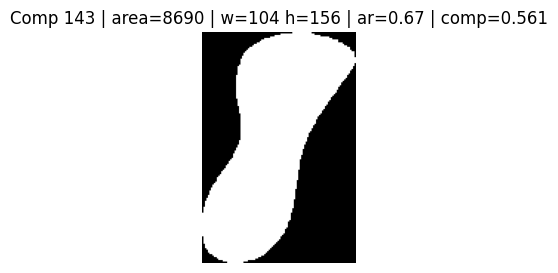

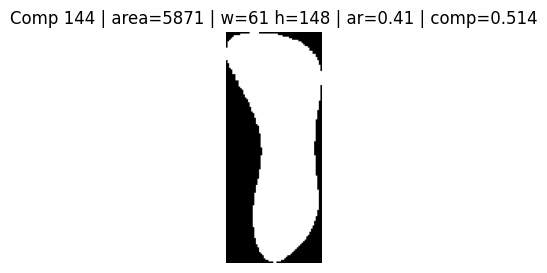

13 potential digits found based on filters
Scoring candidate 4...


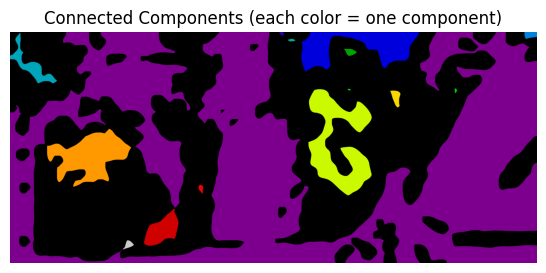

num_labels (including background): 16


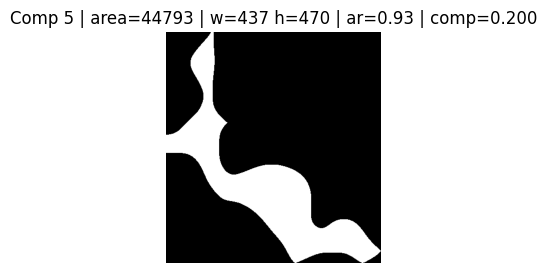

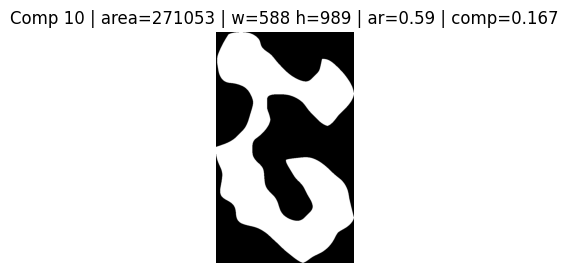

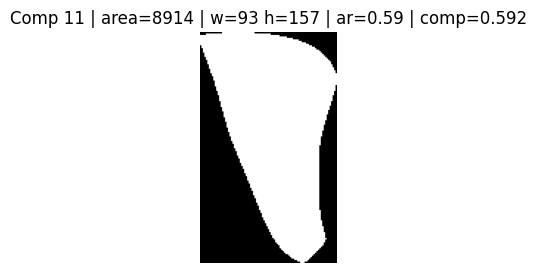

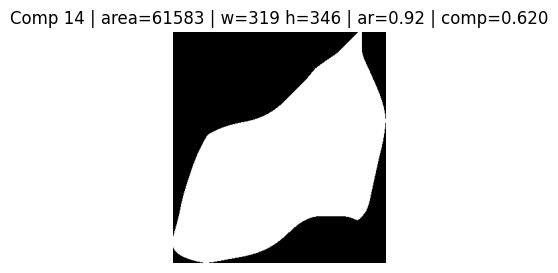

4 potential digits found based on filters
Scoring candidate 5...


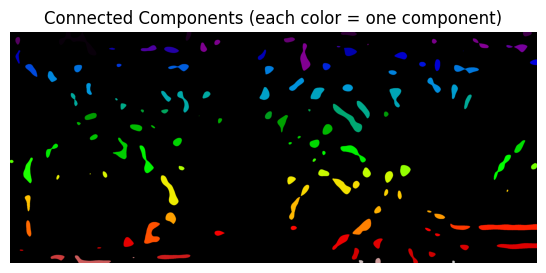

num_labels (including background): 131


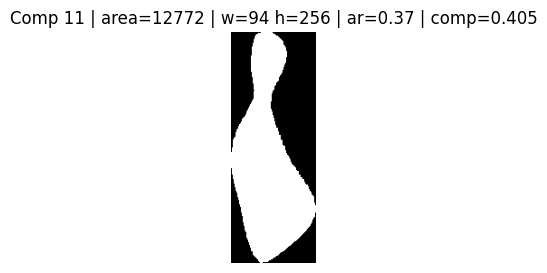

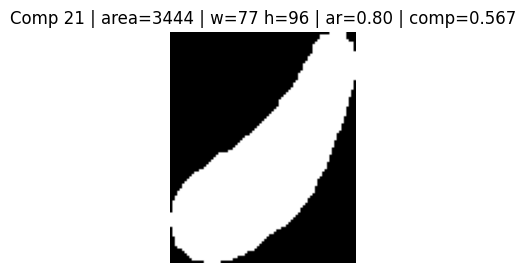

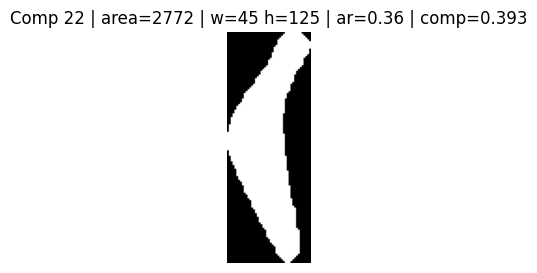

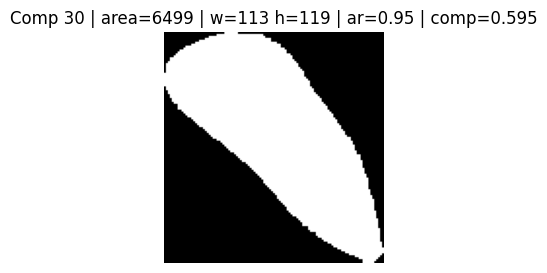

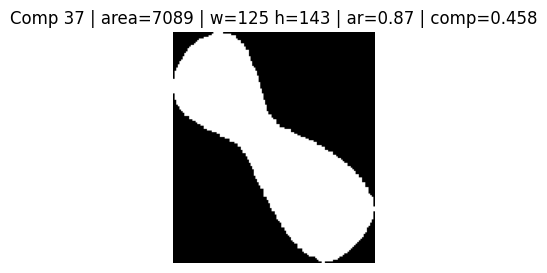

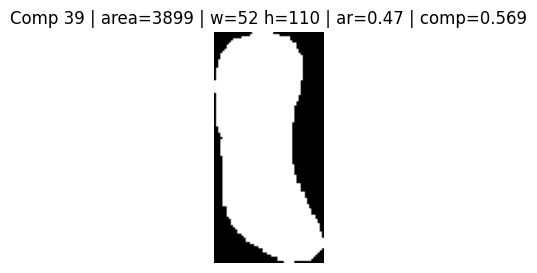

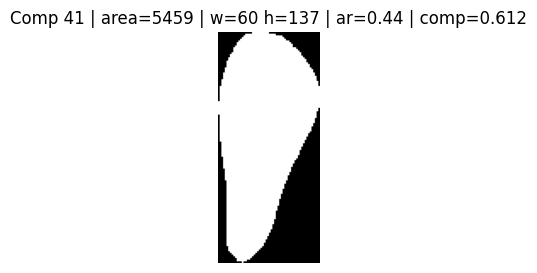

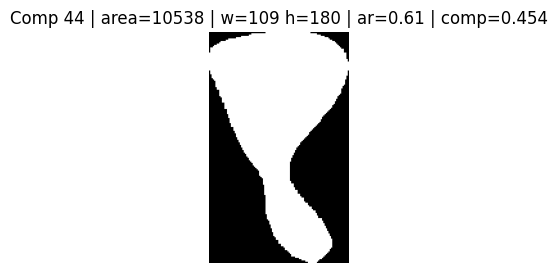

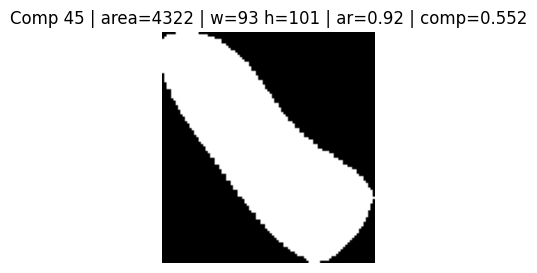

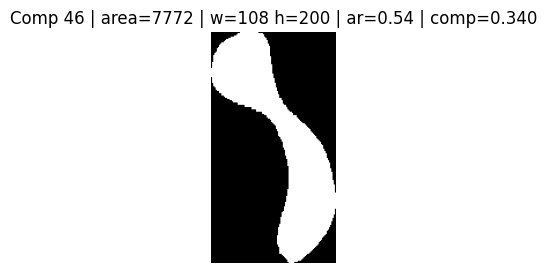

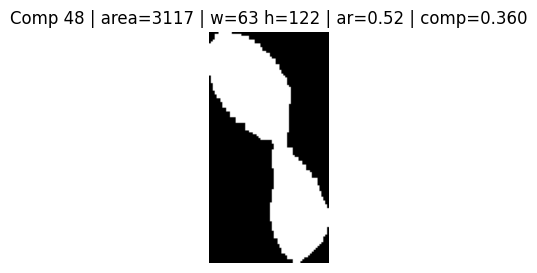

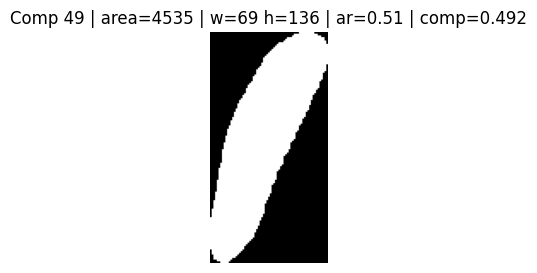

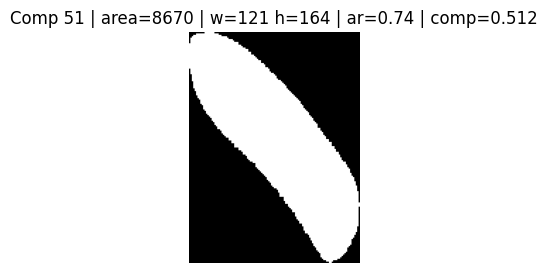

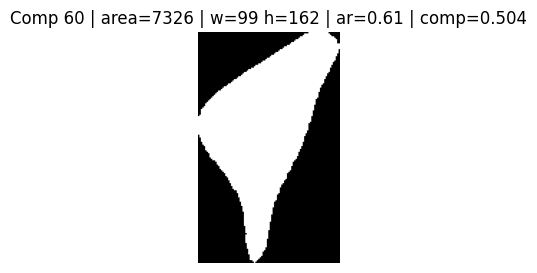

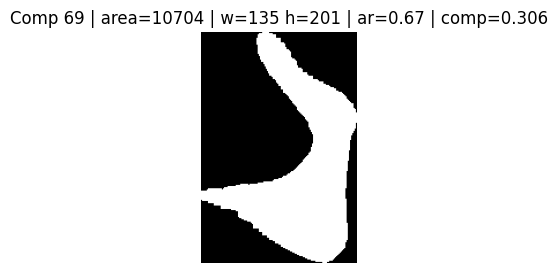

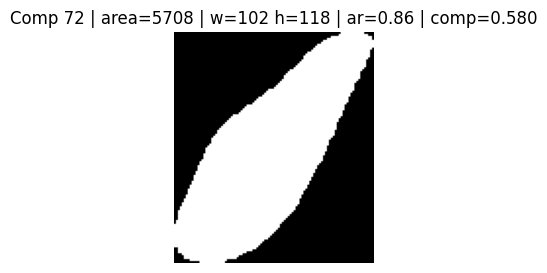

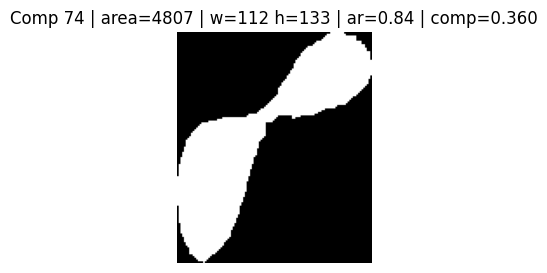

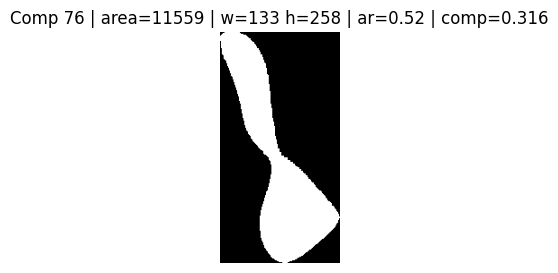

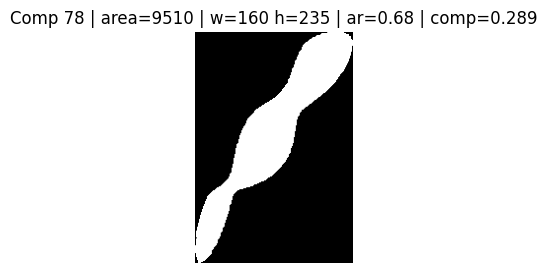

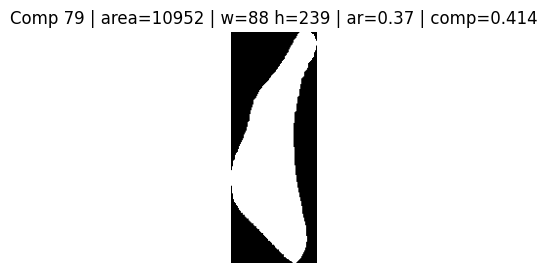

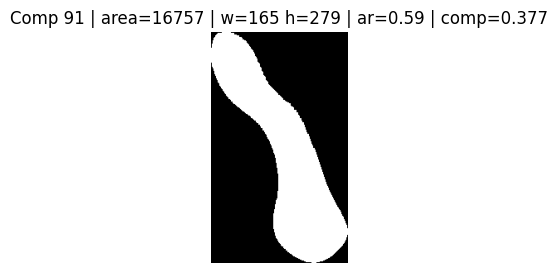

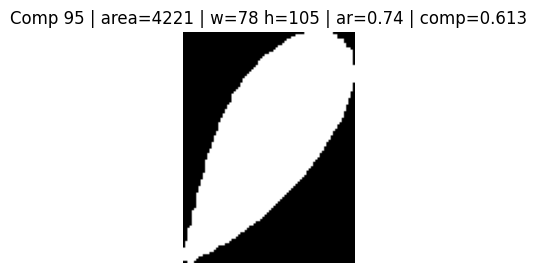

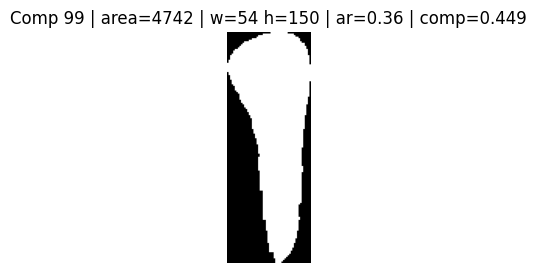

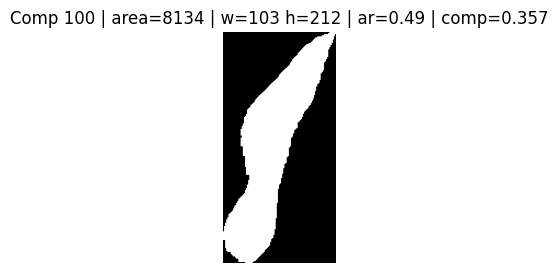

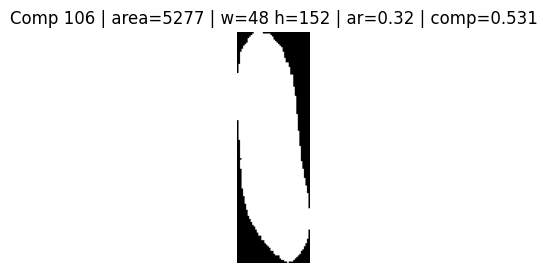

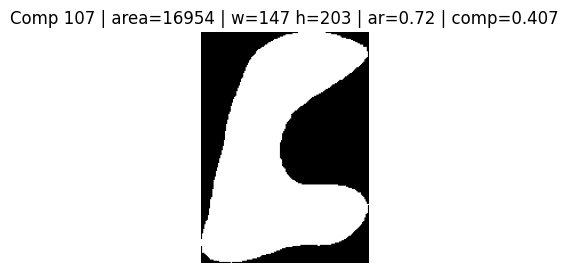

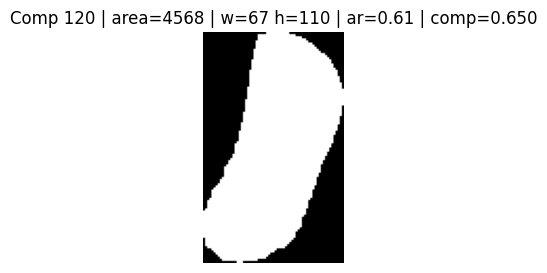

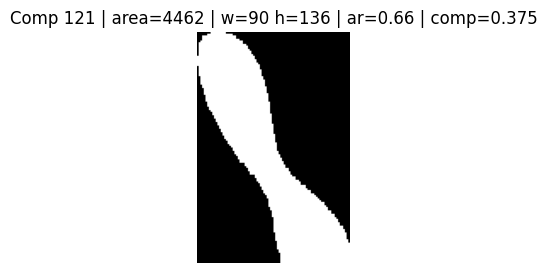

28 potential digits found based on filters
{0: 9, 1: 18, 2: 0, 3: 13, 4: 4, 5: 28}


In [24]:
nd = number_of_digits_in_roi(candidate_rois, debug=True)
print(nd)

In [25]:
max_digits = 10 
min_digits = 7

In [26]:
candidate_index = [(k, v) for k, v in nd.items() if v >= min_digits and v <= max_digits]
candidate_index.sort(reverse=True, key=lambda t: t[1])
print(candidate_index)
 

[(0, 9)]


Candidate 0 has the most digits: 9


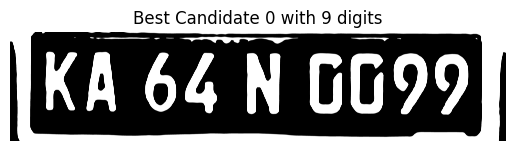

In [27]:
for index, value in candidate_index:
    print(f"Candidate {index} has the most digits: {value}")
    plt.imshow(candidate_rois[index][1], cmap='gray')
    plt.title(f"Best Candidate {index} with {nd[index]} digits")
    plt.axis('off')
    plt.show()
    